# Store Item Prediction - exploration

The goal is to predict sales for the next three month for each item and store.

In [1]:
## Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
## Load data
data = pd.read_csv("./data/train.csv")

## Convert datatypes
data['date'] = pd.to_datetime(data['date'])

## Data exploration

There are 913000 samples. The data range from Jan 2013 to Dec 2017. There are 10 different stores and 50 different items. The sales range from 0 to 231 and follow a chi-square distribution, see below. It is similar for all stores.

In [3]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


Sales range from 0 to 231.


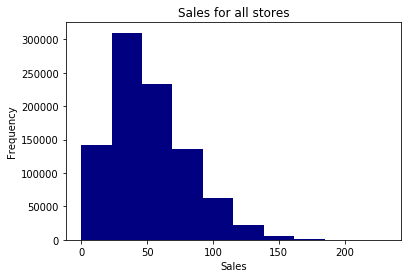

In [4]:
print("Sales range from {} to {}.".format(data['sales'].min(), data['sales'].max()))
plt.hist(data['sales'], color='navy')
plt.title("Sales for all stores")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

In [5]:
data.dtypes

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

In [6]:
data.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
data.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [8]:
print("Data from {} to {}".format(data['date'].min(), data['date'].max()))
print("Number of samples: {}".format(len(data)))
print("Stores: {}".format(data['store'].unique().tolist()))
print("Different items: {}".format(data['item'].unique()))

Data from 2013-01-01 00:00:00 to 2017-12-31 00:00:00
Number of samples: 913000
Stores: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Different items: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


We want to predict sales for the next three month. So let's look at sales over the given time range of one item from one store.

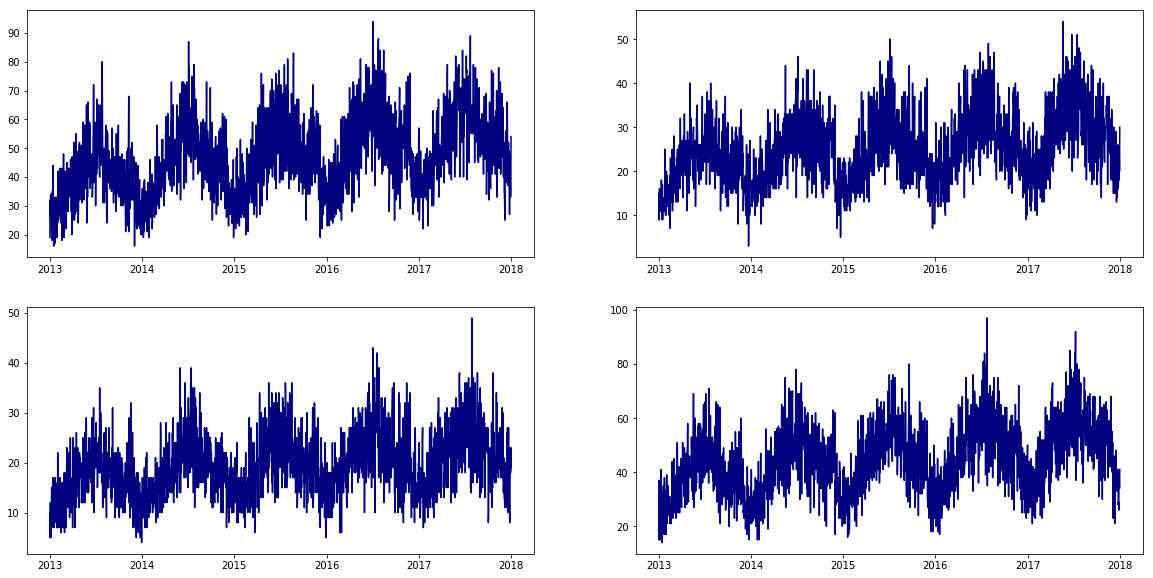

In [9]:
## Sales of one item from one store
plt.figure(figsize=(20,10))

for i in range(4):
    plt.subplot(2, 2, i+1)
    data_slice = data.loc[data['item'] == 3+i]
    data_slice = data_slice.loc[data_slice['store'] == 2+i]
    plt.plot(data_slice['date'], data_slice['sales'], color='navy')

plt.show()

For an item at a store, there is seasonability. The overall trend per year looks similar for most/all? combinations with different levels of noise. Note that no outliers have been filtered yet.

### Pattern identification
There seems to be trend as well as seasonality in the sales on a year scale. Let's investigate these findings in more detail. We also look at patterns on a month and week scale.

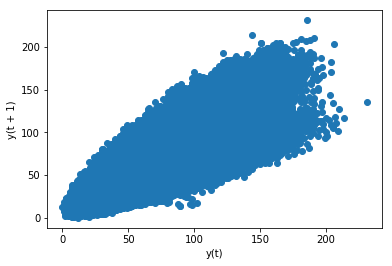

In [17]:
pd.plotting.lag_plot(data['sales'])
plt.show()

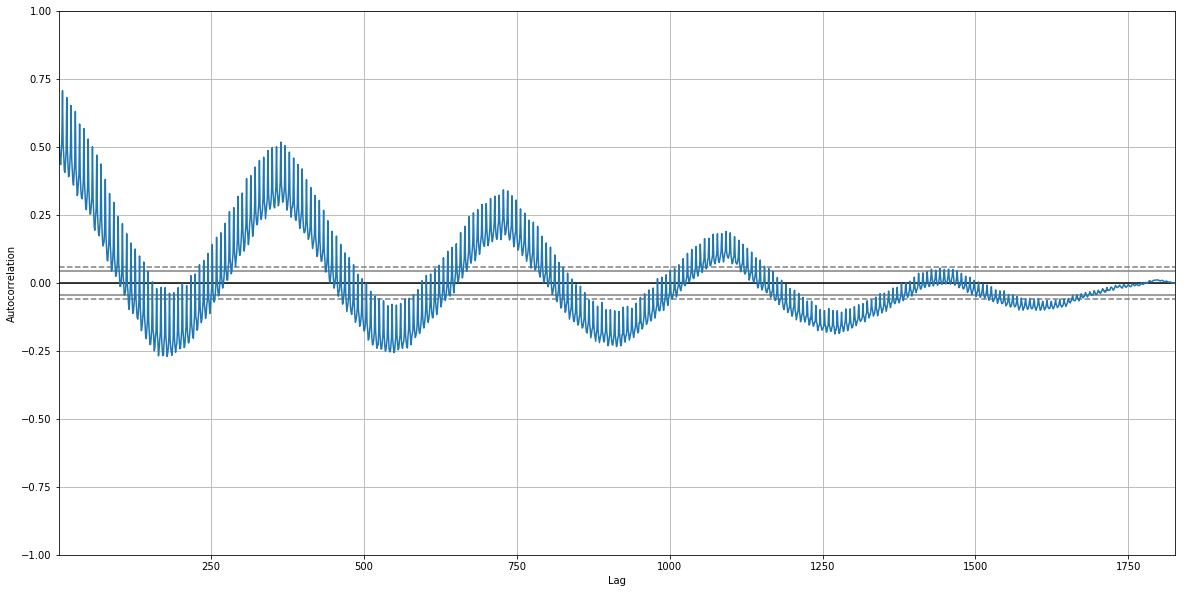

In [14]:
plt.figure(figsize=[20,10])
pd.plotting.autocorrelation_plot(data.loc[data['store'] == int(3)].loc[data['item'] == int(39)]['sales'])
plt.show()

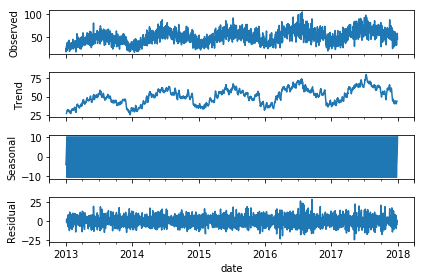

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
test = data.loc[data['store'] == int(3)].loc[data['item'] == int(39)]
test.index = test.date
test = test['sales']

decomposed = seasonal_decompose(test, model='additive')
x = decomposed.plot()

In the lag plot above you can see that the sales are correlated under a lag of 1 between the sales. The second plot shows the autocorrelation under increasing lag. Here you can see the seasonality as well as the trend in the decreasing magnitude. From the third plot four plots you can see that there is a trend on a month scale and a year scale. Next we will investigate these scales in more detail.

### Year scale

Looking at the year 2015 we can see seasonanilty.

In [53]:
data_year = data.loc[(data['date'] >= '2015-01-01') & (data['date'] < '2016-01-01')]

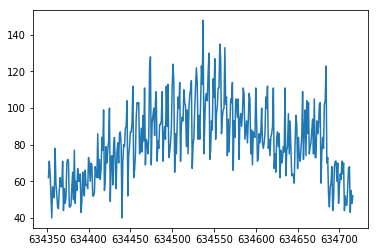

In [55]:
data_year.loc[data_year['store'] == 8].loc[data_year['item'] == 35]['sales'].plot()

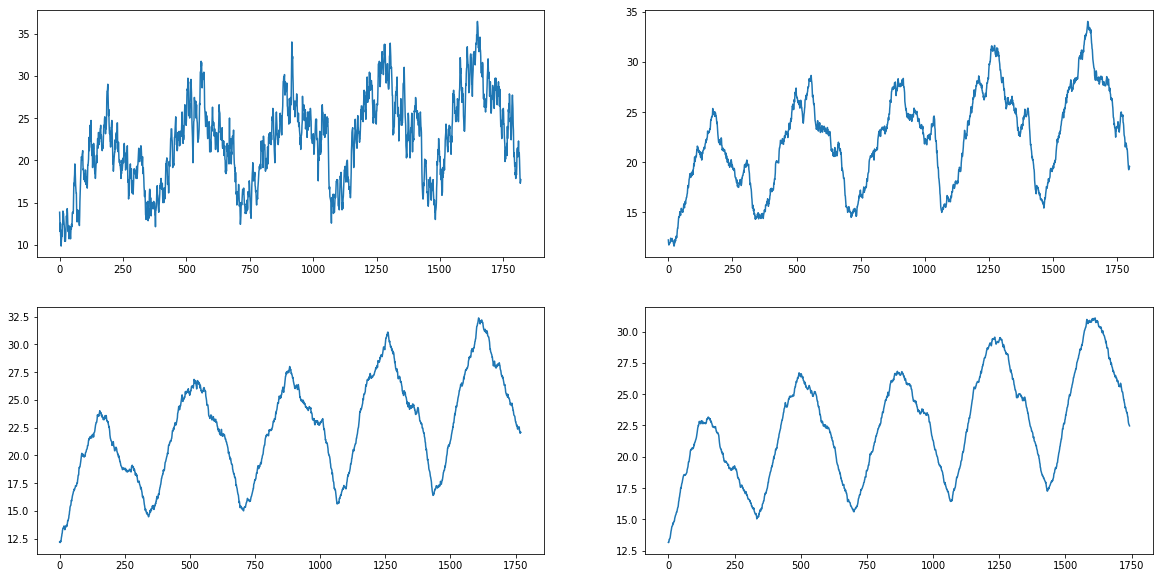

In [59]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


plt.figure(figsize=(20,10))
weeks = [1, 4, 8, 12]
for i in range(4):
    plt.subplot(2, 2, i+1)
    res = moving_average(sales, n=7*(weeks[i]))
    plt.plot(res)
    
plt.show()

The rolling averages over a week and a month show that there seem to be two seasonality scales. The sales seem to vary thoughout a week as well as a month. 

From the rolling average over three month you can see the trend of overall increasing sales.

Let's look at the variation within a month in more detail.

### Month scale

For May 2015 we can see the inner-month seasonality. There is a variation of sales throughout a week.

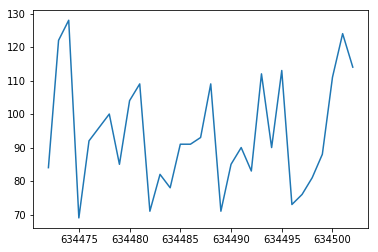

In [66]:
data_month = data_year.loc[(data_year['date'] >= '2015-05-01') & (data_year['date'] < '2015-06-01')]
data_month.loc[data_month['store'] == 8].loc[data_month['item'] == 35]['sales'].plot()

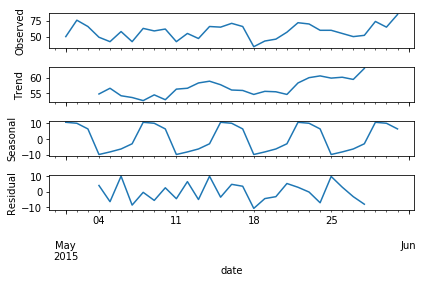

In [67]:
test = data_month.loc[data_month['store'] == int(3)].loc[data_month['item'] == int(39)]
test.index = test.date
test = test['sales']

decomposed = seasonal_decompose(test, model='additive')
x = decomposed.plot()

## Conclusion

The data is complete and clean. There is a trend of increasing sales over the given years. For any combination of store and item there is an increase in sales in the first half of the year and a decrease in the second half. 